#### Extraction code logic for all Shapefile Files

In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from Extract.get_plot import get_plot
from scipy import sparse
import random
import os
from sys import getsizeof

coords = json.load(open('Extract/coords.json'))
mpl.rcParams['figure.dpi'] = 120
# mpl.rcParams['savefig.pad_inches'] = 0

random.seed(10)

# This code is processed 
# I have manually processed every file using this format

directory = r"D:\Users\xubil\OneDrive\Documents\Wildfires Data NPZ\Training"
data = {}

In [3]:
xmin, xmax, ymin, ymax = (coords["limits"]["xmin"]), (coords["limits"]["xmax"]), (coords["limits"]["ymin"]), (coords["limits"]["ymax"])
xminl, xmaxl, yminl, ymaxl = (coords["4326"]["xmin"]), (coords["4326"]["xmax"]), (coords["4326"]["ymin"]), (coords["4326"]["ymax"])

# Extracted datasets Matrix length:
# (59700 * 36400)
extract_x = 59700
extract_y = 36400

xdiff = xmax-xmin
ydiff = ymax-ymin
xmat = int(extract_x * 20000/xdiff)
ymat = int(extract_y * 20000/ydiff) 
mat_l = xmat # xmat and ymat are the same! 


In [3]:
gdf = gpd.read_file(r"D:\Users\xubil\Downloads\Feux_pt_ori_SHP\FEUX_PT_ORI_1972_2022.shp") # Path to the shapefile 

In [4]:
causes = ["Humaine", "Foudre"]
gdf = gdf.to_crs(3857)

In [5]:
gdf

,OBJECTID,CLE,ANNEE,NOFEU,SECTION,CAUSE,DATE_DEBUT,DATE_RAPPO,DATE_ETEIN,SUP_HA,LATITUDE,LONGITUDE,geometry
0,1,20221080001,2022,1,Intensive,Humaine,2022-04-06,2022-04-06,2022-04-06,0.4,45.1289,-72.1135,POINT (-8027638.099 5641837.031)
1,2,20221080002,2022,2,Intensive,Humaine,2022-04-12,2022-04-12,2022-04-12,0.5,45.6624,-74.3352,POINT (-8274956.612 5726412.654)
2,3,20221080003,2022,3,Intensive,Humaine,2022-04-12,2022-04-12,2022-04-12,0.0,45.6734,-74.3641,POINT (-8278173.745 5728164.924)
3,4,20221080004,2022,4,Intensive,Humaine,2022-04-12,2022-04-12,2022-04-12,0.6,45.9701,-77.1305,POINT (-8586127.985 5775559.018)
4,5,20221080005,2022,5,Intensive,Humaine,2022-04-18,2022-04-18,2022-04-18,0.4,45.7227,-74.3818,POINT (-8280144.100 5736022.513)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43235,0,20211080621,2021,621,Intensive,Humaine,2021-10-28,2021-10-28,2021-10-28,0.0,45.4606,-72.1554,POINT (-8032302.386 5694327.352)
43236,0,20211080622,2021,622,Intensive,Humaine,2021-11-09,2021-11-09,2021-11-11,2.0,45.9512,-75.8547,POINT (-8444106.578 5772532.432)
43237,0,20211080623,2021,623,Intensive,Humaine,2021-11-11,2021-11-11,2021-11-11,0.0,45.9812,-74.2104,POINT (-8261063.940 5777337.019)
43238,0,20211080624,2021,624,Intensive,Humaine,2021-11-10,2021-11-16,2021-11-16,0.0,45.3931,-72.1209,POINT (-8028461.864 5683620.797)


In [4]:
def coordsToMat(x, y):
    x = int(((x-xmin)/xdiff)*extract_x)
    y = int(((y-ymin)/ydiff)*extract_y)
    return (x, y)

In [5]:
def matToCoords(x, y):
    x = (x*xdiff)/extract_x+xmin
    y = (y*ydiff)/extract_y+ymin
    return (x,y)

In [6]:
def coordsToLongLat(x, y):
    x = (((x-xmin)/xdiff) * (xmaxl-xminl))+xminl
    y = (((y-ymin)/ydiff) * (ymaxl-yminl))+yminl
    return (x, y)

In [9]:
gdf[gdf["CAUSE"] == "Foudre"].shape

(11908, 13)

In [7]:
def change_zoom(x_min, x_max, y_min, y_max):
    ratio_y, ratio_x = (y_max-y_min)/36400, (x_max-x_min)/59700

    processed = {}
    
    for item in data:
        data_process = data[item][y_min:y_max, x_min:x_max] # To csc speeds up processing

        N, M = data_process.shape
        s, t = int(400*ratio_y), int(400*ratio_x)          # decimation factors for y and x directions
        T = sparse.csc_matrix((np.ones((M,)), np.arange(M), np.r_[np.arange(0, M, t), M]), (M, (M-1) // t + 1))
        S = sparse.csr_matrix((np.ones((N,)), np.arange(N), np.r_[np.arange(0, N, s), N]), ((N-1) // s + 1, N))
        result = S @ data_process @ T     # downsample by binning into s x t rectangles
        processed[item] = result.todense() 
    
    return processed 

In [11]:
def change_zoom_retarr(x_min, x_max, y_min, y_max, reduceres = False):
    ratio_y, ratio_x = (y_max-y_min)/36400, (x_max-x_min)/59700
    
    processed = []

    for subdir in data:

        for filename in data[subdir]:

            data_process = data[subdir][filename][y_min:y_max, x_min:x_max] # To csc speeds up processing
            
            if reduceres:
                N, M = data_process.shape
                s, t = 2, 2         # decimation factors for y and x directions
                T = sparse.csc_matrix((np.ones((M,)), np.arange(M), np.r_[np.arange(0, M, t), M]), (M, (M-1) // t + 1))
                S = sparse.csr_matrix((np.ones((N,)), np.arange(N), np.r_[np.arange(0, N, s), N]), ((N-1) // s + 1, N))
                result = S @ data_process @ T     # downsample by binning into s x t rectangles
                processed.append(result.todense())
            else:
                processed.append(data_process)
    
    return processed

In [8]:
for filename in os.listdir(directory):
    print("Reading from ",filename)

    if (filename == 'Ignore'):
        continue

    data[filename] = sparse.load_npz(os.path.join(directory, filename))

Reading from  Forets Feuillus.npz
Reading from  Forets Melanges.npz
Reading from  Forets Resineux.npz
Reading from  Hyposometrie.npz
Reading from  Ignore
Reading from  Lignes.npz
Reading from  Routes.npz


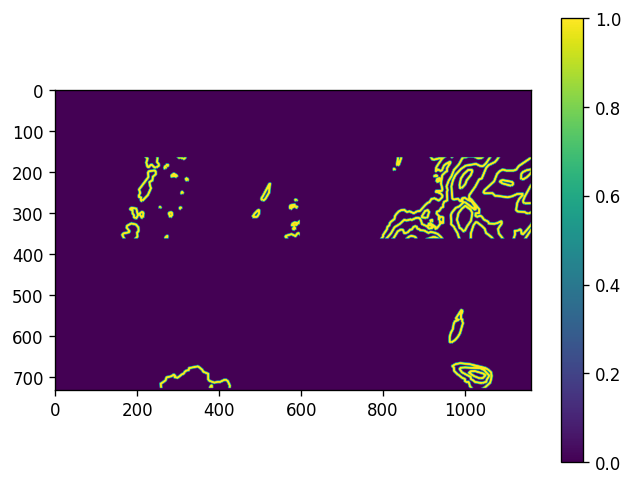

In [10]:
plt.imshow(data["Hyposometrie.npz"][14560:15293, 17910:19073].todense())
plt.colorbar()
plt.show()

### Process Training Data

In [13]:
# count = 0

# for cause in causes:
#     print(cause)
#     trainingInput = []

#     for point in gdf[gdf["CAUSE"] == cause].iterrows():
#         rand = random.random() # Set seed makes the dataset generated always the same <3
#         # rand 0-1 number determines the where exactly the grid cropped (only if possible if we are at bounds it will auto-adjust to fit bounds)

#         # # # # # # # # #^
#         #               #✓ The length of height and width offset is the same!!! 
#         #    P          #
#         #               #     
#         #               #
#         #               #
#         # # # # # # # # #
#         #<->

#         # print(point)
#         print(count)

#         rxcoord, rycoord = point[1]["geometry"].bounds[0], point[1]["geometry"].bounds[1]

#         # print(rxcoord, rycoord)

#         if not (rxcoord >= xmin and rxcoord <= xmax and rycoord >= ymin and rycoord <= ymax):
#             continue
        
#         xcoord, ycoord = coordsToMat(rxcoord, rycoord)

#         # print(xcoord, ycoord)

#         min_x, min_y = xcoord-int(rand*mat_l), ycoord-int(rand*mat_l)
#         max_x, max_y = min_x+mat_l-1, min_y+mat_l-1

#         # print(min_x, max_x, min_y, max_y)

#         # Shift the square if it is out of boundsss 
#         if (min_x < 0):
#             min_x = 0
#             max_x = mat_l-1
#         if (min_y < 0):
#             min_y = 0
#             max_y = mat_l-1
#         if (max_x >= extract_x):
#             max_x = extract_x-1
#             min_x = extract_x-mat_l
#         if (max_y >= extract_y):
#             max_y = extract_y-1
#             min_y = extract_y-mat_l
        
#         minxc, minyc = matToCoords(min_x, min_y)
#         minxc, minyc = coordsToLongLat(minxc, minyc)
#         maxxc, maxyc = matToCoords(max_x, max_y)
#         maxxc, maxyc = coordsToLongLat(maxxc, maxyc)
#         # Here we would fetch weather data for our second dataset with weather

#         # print(min_x, max_x, min_y, max_y)

#         processed = change_zoom_retarr(min_x, max_x, min_y, max_y)
#         # print(getsizeof(processed))
#         # print(len(processed[0]))

#         trainingInput.append(processed)
#         # print(getsizeof(trainingInput))
#         del processed
#         count+=1

#         # if (count > 100):
#         #     break
#         # count+=1
#     # break
#     np.save('Training/No Weather/'+cause, trainingInput)
#     del trainingInput

#     break
        

        

In [14]:
trainingInput = []
cause = "Humaine"

random.seed(10)

for point in gdf[gdf["CAUSE"] == cause].iterrows():
        rand = random.random() # Set seed makes the dataset generated always the same <3
        # rand 0-1 number determines the where exactly the grid cropped (only if possible if we are at bounds it will auto-adjust to fit bounds)

        # # # # # # # # #^
        #               #✓ The length of height and width offset is the same!!! 
        #    P          #
        #               #     
        #               #
        #               #
        # # # # # # # # #
        #<->

        # print(point)
        # print(count)

        rxcoord, rycoord = point[1]["geometry"].bounds[0], point[1]["geometry"].bounds[1]

        # print(rxcoord, rycoord)

        if not (rxcoord >= xmin and rxcoord <= xmax and rycoord >= ymin and rycoord <= ymax):
            continue
        
        xcoord, ycoord = coordsToMat(rxcoord, rycoord)

        # print(xcoord, ycoord)

        min_x, min_y = xcoord-int(rand*mat_l), ycoord-int(rand*mat_l)
        max_x, max_y = min_x+mat_l-1, min_y+mat_l-1

        # print(min_x, max_x, min_y, max_y)

        # Shift the square if it is out of boundsss 
        if (min_x < 0):
            min_x = 0
            max_x = mat_l-1
        if (min_y < 0):
            min_y = 0
            max_y = mat_l-1
        if (max_x >= extract_x):
            max_x = extract_x-1
            min_x = extract_x-mat_l
        if (max_y >= extract_y):
            max_y = extract_y-1
            min_y = extract_y-mat_l
        
        minxc, minyc = matToCoords(min_x, min_y)
        minxc, minyc = coordsToLongLat(minxc, minyc)
        maxxc, maxyc = matToCoords(max_x, max_y)
        maxxc, maxyc = coordsToLongLat(maxxc, maxyc)
        # Here we would fetch weather data for our second dataset with weather

        # print(min_x, max_x, min_y, max_y)

        processed = change_zoom_retarr(min_x, max_x, min_y, max_y)
        # print(getsizeof(processed))
        # print(len(processed[0]))

        trainingInput.append(processed)
        # print(getsizeof(trainingInput))
        del processed
        # count+=1

        # if (count > 100):
        #     break
        # count+=1
    # break
np.save('Training/No Weather/'+cause, trainingInput)
del trainingInput